In [1]:
import cv2
import numpy as np
import os

Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.


### rotating tif masks

In [3]:
def clean_edges(edges):
    blurred = cv2.GaussianBlur(edges, (5, 5), 0)
    kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (3, 3))
    dilated = cv2.dilate(blurred, kernel, iterations=1)
    cleaned_edges = cv2.erode(dilated, kernel, iterations=1)
    return cleaned_edges

# Find the largest contour by area
def find_largest_contour(contours):
    largest_contour = max(contours, key=cv2.contourArea)
    return largest_contour

# Fill a contour to create a mask of the shape
def fill_contour(img_shape, contour):
    mask = np.zeros(img_shape, dtype=np.uint8)
    cv2.drawContours(mask, [contour], -1, 255, thickness=cv2.FILLED)
    return mask

# Calculate the center of mass of a filled contour
def get_center_of_mass(mask):
    M = cv2.moments(mask)
    if M["m00"] != 0:
        cX = int(M["m10"] / M["m00"])
        cY = int(M["m01"] / M["m00"])
    else:
        cX, cY = mask.shape[1] // 2, mask.shape[0] // 2  # Default to center if no mass
    return cX, cY

# Center the image based on center of mass
def center_image(mask):
    cX, cY = get_center_of_mass(mask)
    shiftX = mask.shape[1] // 2 - cX
    shiftY = mask.shape[0] // 2 - cY
    translation_matrix = np.float32([[1, 0, shiftX], [0, 1, shiftY]])
    centered_mask = cv2.warpAffine(mask, translation_matrix, (mask.shape[1], mask.shape[0]))
    return centered_mask

# Combines the above functions for the pipeline
def pipeline_helper(tif_path):
    image = cv2.imread(tif_path, 0)
    edges = cv2.Canny(image, 50, 100)
    cleaned_edges = clean_edges(edges)
    contours, _ = cv2.findContours(cleaned_edges, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    largest_contour = find_largest_contour(contours)
    mask = fill_contour(cleaned_edges.shape, largest_contour)
    centered_mask = center_image(mask)
    return centered_mask

In [4]:
# Rotate the image around its center
def rotate_image(image, angle):
    h, w = image.shape[:2]
    center = (w // 2, h // 2)
    rotation_matrix = cv2.getRotationMatrix2D(center, angle, 1.0)
    rotated_image = cv2.warpAffine(image, rotation_matrix, (w, h))
    return rotated_image

# Pad an image symmetrically to match the target size
def pad_to_size(image, target_size):
    h, w = image.shape[:2]
    pad_top = (target_size[1] - h) // 2
    pad_bottom = target_size[1] - h - pad_top
    pad_left = (target_size[0] - w) // 2
    pad_right = target_size[0] - w - pad_left
    padded_image = np.pad(image, ((pad_top, pad_bottom), (pad_left, pad_right)), mode='constant', constant_values=0)
    return padded_image


In [5]:
# Mirror the image either horizontally or vertically
def mirror_image(image, direction='horizontal'):
    if direction == 'horizontal':
        mirrored_image = cv2.flip(image, 1)  # Horizontal flip
    elif direction == 'vertical':
        mirrored_image = cv2.flip(image, 0)  # Vertical flip
    else:
        raise ValueError("Direction should be either 'horizontal' or 'vertical'")
    return mirrored_image

# Function to find the optimal rotation and flip for alignment
def find_best_rotation_with_flip(mask1, mask2, angles=np.arange(-90, 91, 1)):
    best_overlap = 0
    best_angle = 0
    best_flip = None

    for flip in [None, 'horizontal', 'vertical']:
        flipped_mask2 = mirror_image(mask2, flip) if flip else mask2
        for angle in angles:
            rotated_mask2 = rotate_image(flipped_mask2, angle)
            intersection = cv2.bitwise_and(mask1, rotated_mask2)
            union = cv2.bitwise_or(mask1, rotated_mask2)
            similarity_score = np.sum(intersection) / np.sum(union)

            if similarity_score > best_overlap:
                best_overlap = similarity_score
                best_angle = angle
                best_flip = flip

    return best_overlap, best_angle, best_flip


In [6]:
# Main pipeline with optimal flip function
def pipeline_with_optimal_flip(path1, path2, path3):
    mask1 = pipeline_helper(path1)
    mask2 = pipeline_helper(path2)
    mask3 = pipeline_helper(path3)

    # Step 1: Get maximum width and height to resize all three images
    max_width = max(mask1.shape[1], mask2.shape[1], mask3.shape[1])
    max_height = max(mask1.shape[0], mask2.shape[0], mask3.shape[0])

    # Step 2: Resize and pad all masks to the same size
    mask1 = pad_to_size(mask1, (max_width, max_height))
    mask2 = pad_to_size(mask2, (max_width, max_height))
    mask3 = pad_to_size(mask3, (max_width, max_height))

    # Step 3: Find the best rotation and flip for mask2 that maximizes overlap with mask1
    best_overlap_2, angle2, flip2 = find_best_rotation_with_flip(mask1, mask2)
    mask2_flipped = mirror_image(mask2, flip2) if flip2 else mask2
    mask2_transformed = rotate_image(mask2_flipped, angle2)

    # Step 4: Find the best rotation and flip for mask3 that maximizes overlap with the transformed mask2
    best_overlap_3, angle3, flip3 = find_best_rotation_with_flip(mask1, mask3)
    mask3_flipped = mirror_image(mask3, flip3) if flip3 else mask3
    mask3_transformed = rotate_image(mask3_flipped, angle3)

    return mask1, mask2, mask3, mask2_transformed, mask3_transformed, angle2, flip2, angle3, flip3


In [7]:
paths = ['patient1/h1810898A h&e_ROI_1.tif', 'patient1/h1810898A mela_ROI_1.tif', 'patient1/h1810898A sox10_ROI_1.tif']

he, melana, sox, melana_rotated, sox_rotated, angle2, flip2, angle3, flip3 = pipeline_with_optimal_flip(paths[0], paths[1], paths[2])

In [8]:
# Create a 3x3 kernel for morphological operations
kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (3, 3))


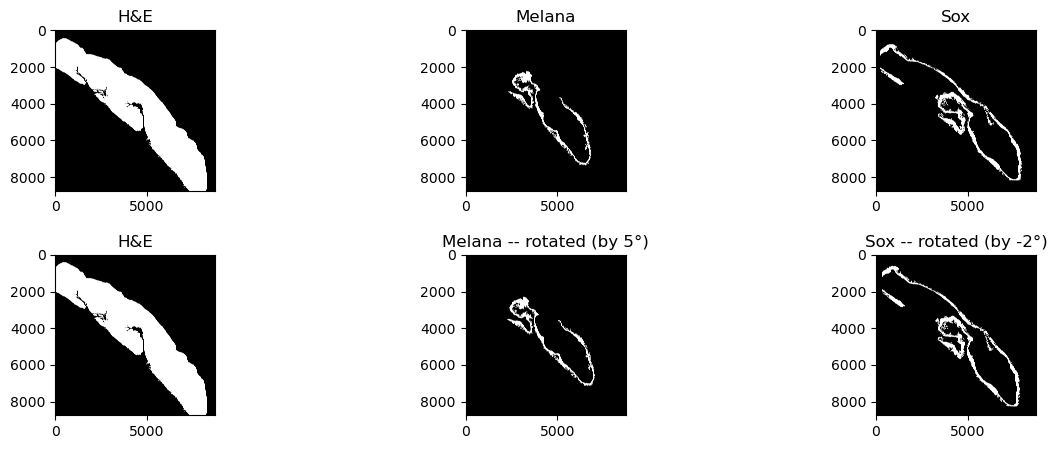

In [10]:
plt.figure(figsize=(15, 5))

# Original images
plt.subplot(2, 3, 1)
plt.title('H&E')
plt.imshow(he, cmap='gray')

plt.subplot(2, 3, 2)
plt.title('Melana')
plt.imshow(melana, cmap='gray')

plt.subplot(2, 3, 3)
plt.title('Sox')
plt.imshow(sox, cmap='gray')

# Transformed images with rotation and flip information
plt.subplot(2, 3, 4)
plt.title('H&E')
plt.imshow(he, cmap='gray')

# Show rotation and flip information for Melana
melana_flip_info = f", flipped {flip2}" if flip2 else ""
plt.subplot(2, 3, 5)
plt.title(f'Melana -- rotated (by {angle2}°{melana_flip_info})')
plt.imshow(melana_rotated, cmap='gray')

# Show rotation and flip information for Sox
sox_flip_info = f", flipped {flip3}" if flip3 else ""
plt.subplot(2, 3, 6)
plt.title(f'Sox -- rotated (by {angle3}°{sox_flip_info})')
plt.imshow(sox_rotated, cmap='gray')

# Adjust spacing between subplots
plt.subplots_adjust(hspace=0.4)

plt.show()


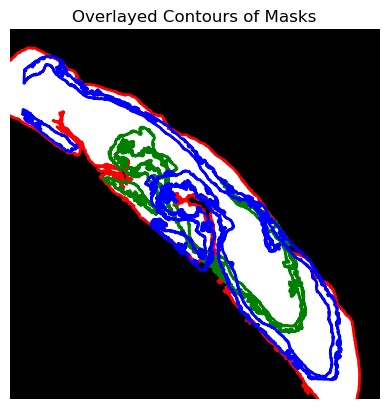

In [11]:
# Find contours for each mask
he_contours = find_contours(he, level=0.5)
melana_contours = find_contours(melana_rotated, level=0.5)
sox_contours = find_contours(sox_rotated, level=0.5)

# Plot the base image (you can choose to use one of the images or any other background)
plt.imshow(he, cmap='gray')  # Replace `he` with the desired base image

# Plot contours of each mask on top of the base image
for contour in he_contours:
    plt.plot(contour[:, 1], contour[:, 0], color='red', lw=2)  # Red contours for H&E

for contour in melana_contours:
    plt.plot(contour[:, 1], contour[:, 0], color='green', lw=2)  # Green contours for melana

for contour in sox_contours:
    plt.plot(contour[:, 1], contour[:, 0], color='blue', lw=2)  # Green contours for sox10

# Plot
plt.title('Overlayed Contours of Masks')
plt.axis('off')  # Hide axis
plt.show()


### area matching

### aligning

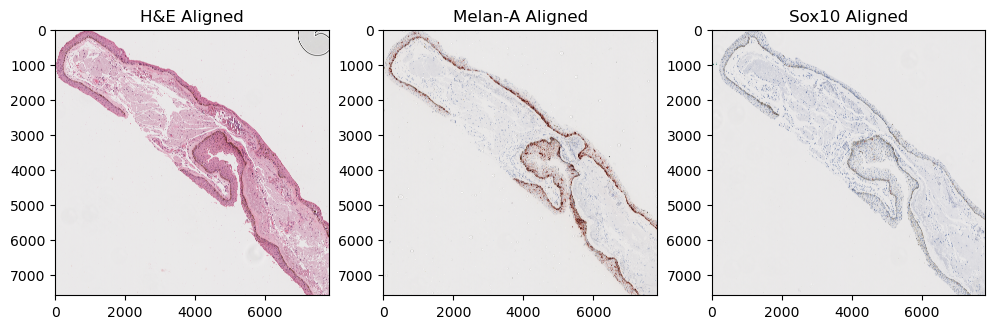

In [51]:
# Function to clean the edges of an image
def clean_edges(edges):
    blurred = cv2.GaussianBlur(edges, (5, 5), 0)
    kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (3, 3))
    dilated = cv2.dilate(blurred, kernel, iterations=1)
    cleaned_edges = cv2.erode(dilated, kernel, iterations=1)
    return cleaned_edges

# Find the largest contour by area
def find_largest_contour(image):
    contours, _ = cv2.findContours(image, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    return max(contours, key=cv2.contourArea)

# Resize an image to match the dimensions of the target contour
def resize_image_to_contour(image, target_contour):
    target_bbox = cv2.boundingRect(target_contour)  # Get bounding box of the target contour
    target_width, target_height = target_bbox[2], target_bbox[3]

    # Resize the image
    resized_image = cv2.resize(image, (target_width, target_height), interpolation=cv2.INTER_LINEAR)
    return resized_image

# Align contours by scaling and translating
def align_images(base_image, target_image, base_contour, target_contour):
    # Get bounding boxes for the contours
    base_bbox = cv2.boundingRect(base_contour)
    target_bbox = cv2.boundingRect(target_contour)

    # Calculate scaling factor
    scale_x = base_bbox[2] / target_bbox[2]
    scale_y = base_bbox[3] / target_bbox[3]

    # Resize the target image and contour
    resized_target = cv2.resize(target_image, None, fx=scale_x, fy=scale_y, interpolation=cv2.INTER_LINEAR)
    resized_target_contour = np.array(target_contour * [scale_x, scale_y], dtype=np.int32)

    # Translate the resized target to match the base contour
    dx = base_bbox[0] - target_bbox[0] * scale_x
    dy = base_bbox[1] - target_bbox[1] * scale_y

    translation_matrix = np.float32([[1, 0, dx], [0, 1, dy]])
    translated_target = cv2.warpAffine(resized_target, translation_matrix, (base_image.shape[1], base_image.shape[0]))

    return translated_target

# Crop images to a common ROI
def crop_to_common_roi(images, contours):
    # Find the intersection of bounding boxes
    bboxes = [cv2.boundingRect(contour) for contour in contours]
    x_min = max(b[0] for b in bboxes)
    y_min = max(b[1] for b in bboxes)
    x_max = min(b[0] + b[2] for b in bboxes)
    y_max = min(b[1] + b[3] for b in bboxes)

    # Crop images to the common ROI
    cropped_images = [img[y_min:y_max, x_min:x_max] for img in images]
    return cropped_images

# Main pipeline
def process_images(paths):
    # Load images
    images = [cv2.imread(path, cv2.IMREAD_COLOR) for path in paths]

    # Convert images to grayscale and clean up edges
    gray_images = [cv2.cvtColor(img, cv2.COLOR_BGR2GRAY) for img in images]
    cleaned_images = [clean_edges(cv2.adaptiveThreshold(gray, 255, cv2.ADAPTIVE_THRESH_MEAN_C, 
                                                        cv2.THRESH_BINARY, 11, 2)) for gray in gray_images]

    # Find largest contours
    contours = [find_largest_contour(cleaned) for cleaned in cleaned_images]

    # Resize and align images to the largest contour (H&E as base)
    base_image = images[0]
    aligned_images = [base_image]  # Start with the base image
    for i in range(1, len(images)):
        aligned_image = align_images(base_image, images[i], contours[0], contours[i])
        aligned_images.append(aligned_image)

    # Crop to the common ROI
    cropped_images = crop_to_common_roi(aligned_images, contours)

    return cropped_images

# Example paths
paths = ['patient1/h1810898A h&e_ROI_1.tif', 'patient1/h1810898A mela_ROI_1.tif', 'patient1/h1810898A sox10_ROI_1.tif']

# Process images
processed_images = process_images(paths)

# Visualize the processed images
plt.figure(figsize=(12, 8))
titles = ['H&E Aligned', 'Melan-A Aligned', 'Sox10 Aligned']
for i, img in enumerate(processed_images):
    plt.subplot(1, 3, i + 1)
    plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
    plt.title(titles[i])
plt.show()


All images are scaled and translated to match the largest contour of the base image


All images are cropped to max contour and scaled with that contour, not the true image dimension size

### after alignment, bounding box + using same coordinates

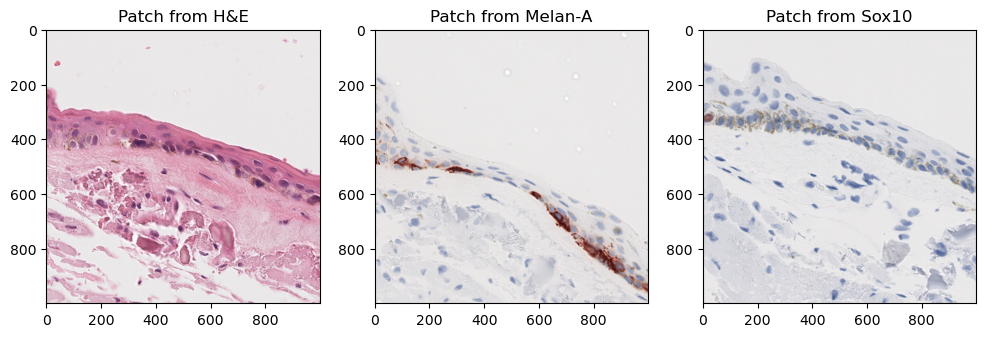

In [61]:
import random
import cv2
import numpy as np
import matplotlib.pyplot as plt

# Function to clean the edges of the image using adaptive thresholding
def clean_edges(image):
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    thresh = cv2.adaptiveThreshold(
        gray, 255, cv2.ADAPTIVE_THRESH_MEAN_C, cv2.THRESH_BINARY, 11, 2
    )
    return thresh

# Find the largest contour by area
def find_largest_contour(image):
    contours, _ = cv2.findContours(image, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    return max(contours, key=cv2.contourArea)

# Calculate the common bounding box from contours of all images
def get_common_bounding_box(contours):
    x_min = min(cv2.boundingRect(c)[0] for c in contours)
    y_min = min(cv2.boundingRect(c)[1] for c in contours)
    x_max = max(cv2.boundingRect(c)[0] + cv2.boundingRect(c)[2] for c in contours)
    y_max = max(cv2.boundingRect(c)[1] + cv2.boundingRect(c)[3] for c in contours)
    return x_min, y_min, x_max - x_min, y_max - y_min

# Crop images to the common ROI
def crop_to_common_roi(images, bounding_box):
    x, y, w, h = bounding_box
    return [img[y:y+h, x:x+w] for img in images]

# Function to extract a patch from specified coordinates in an image
def extract_patch(image, start_x, start_y, patch_size):
    return image[start_y:start_y+patch_size[1], start_x:start_x+patch_size[0]]

# Main pipeline for processing and patch extraction
def process_images(paths, patch_size=(100, 100)):
    images = [cv2.imread(path) for path in paths]
    processed_images = [clean_edges(img) for img in images]
    contours = [find_largest_contour(proc) for proc in processed_images]
    
    # Get common bounding box from contours
    bounding_box = get_common_bounding_box(contours)
    cropped_images = crop_to_common_roi(images, bounding_box)

    # Select a random point within the cropped region of the first image (H&E)
    h, w = cropped_images[0].shape[:2]
    x = random.randint(0, w - patch_size[0])
    y = random.randint(0, h - patch_size[1])

    # Extract patches from the same coordinates in all images
    patches = [extract_patch(img, x, y, patch_size) for img in cropped_images]
    
    return patches

# Visualization function
def visualize_patches(patches, titles):
    plt.figure(figsize=(12, 4))
    for i, patch in enumerate(patches):
        plt.subplot(1, len(patches), i + 1)
        plt.imshow(cv2.cvtColor(patch, cv2.COLOR_BGR2RGB))
        plt.title(titles[i])
    plt.show()

# Example usage
paths = ['patient1/h1810898A h&e_ROI_1.tif',
         'patient1/h1810898A mela_ROI_1.tif',
         'patient1/h1810898A sox10_ROI_1.tif']

patch_size = (1000, 1000)
titles = ['Patch from H&E', 'Patch from Melan-A', 'Patch from Sox10']

# Process and extract patches
patches = process_images(paths, patch_size)

# Visualize results
visualize_patches(patches, titles)


what it does:

aligns the images so that the same coordinates can be used

calculates a bounding box that finds a point/box that is in the same largest contour for all three images